https://www.coursera.org/lecture/convolutional-neural-networks/anchor-boxes-yNwO0
    
https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab
    
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

In [3]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [4]:
files

[PosixPath('../DATA/airbus-ship/segmentations'),
 PosixPath('../DATA/airbus-ship/classification'),
 PosixPath('../DATA/airbus-ship/test_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/detections'),
 PosixPath('../DATA/airbus-ship/test_dummy'),
 PosixPath('../DATA/airbus-ship/test_all'),
 PosixPath('../DATA/airbus-ship/sample_submission.csv'),
 PosixPath('../DATA/airbus-ship/tmp'),
 PosixPath('../DATA/airbus-ship/models'),
 PosixPath('../DATA/airbus-ship/train_all'),
 PosixPath('../DATA/airbus-ship/train_ship_segmentations.csv')]

### visualize detection data

In [24]:
from skimage.measure import regionprops
from eval_metric import get_gt_masks
from seg_plots import show_imgmasks

In [75]:
# images with ships
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [105]:
ship_id = np.random.choice(train_seg_lbs.ImageId)
gt_rles = train_seg_lbs[train_seg_lbs.ImageId == ship_id]['EncodedPixels'].values
len(gt_rles)

8

In [106]:
img = open_image(path/"train_all"/ship_id)

In [107]:
gt_masks = get_gt_masks(gt_rles)

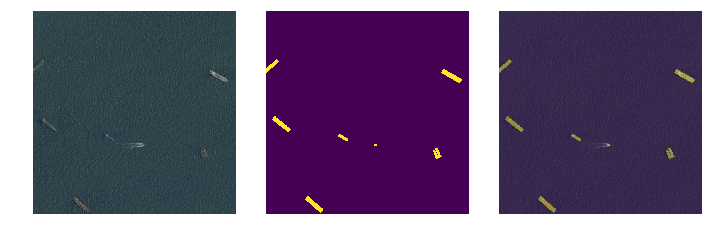

In [108]:
show_imgmasks(img, sum(gt_masks))

In [109]:
props = [regionprops(gt_mask) for gt_mask in gt_masks]

In [110]:
bboxes = [prop[0]['bbox'] for prop in props]

In [111]:
props

[[<skimage.measure._regionprops._RegionProperties at 0x7f46cce91390>],

In [115]:
from detect_plots import draw_bbox

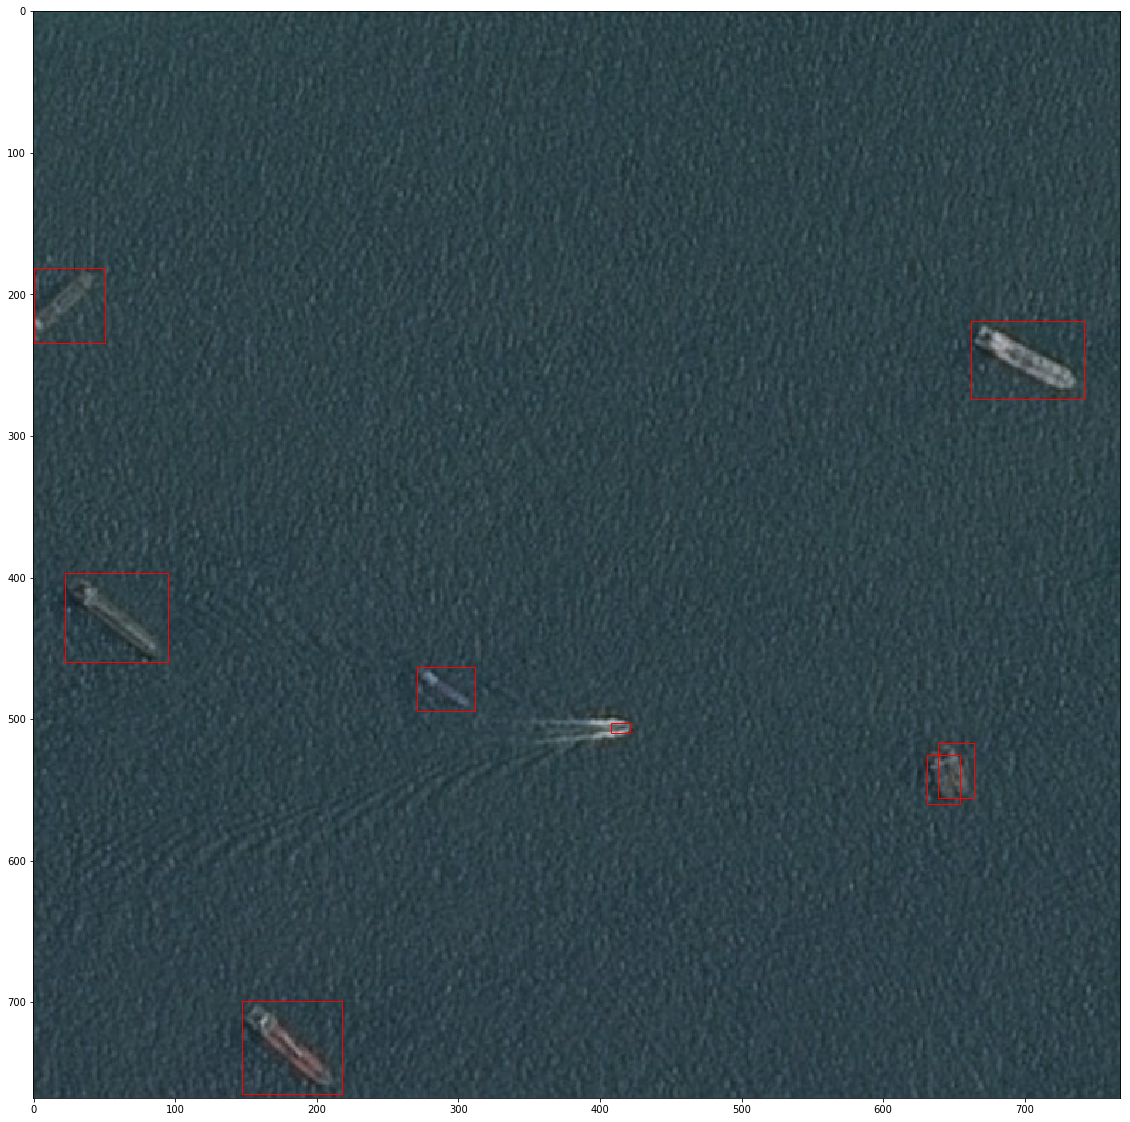

In [116]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(img)
for bbox in bboxes: draw_bbox(bbox, axes)

### create object detection data

In [196]:
train_ship_ids = train_seg_lbs.ImageId.unique()
test_ship_ids = test_seg_lbs.ImageId.unique()

#### train

In [ ]:
df = train_seg_lbs
ship_id_bbox = []

for img_id in train_ship_ids:
    gt_rles = df[df.ImageId == img_id]['EncodedPixels'].values
    gt_masks = get_gt_masks(gt_rles)
    props = [regionprops(gt_mask) for gt_mask in gt_masks]
    bboxes = [prop[0]['bbox'] for prop in props]
    n = len(ship_id_bbox)
    for bbox in bboxes: ship_id_bbox.append((img_id, bbox))

In [ ]:
ship_ids, bboxes = list(zip(*ship_id_bbox))
train_bbox_lbs = pd.DataFrame({"ImageId": ship_ids, "BoundingBox": bboxes})

#### test

In [ ]:
df = test_seg_lbs
ship_id_bbox = []

for img_id in test_ship_ids:
    gt_rles = df[df.ImageId == img_id]['EncodedPixels'].values
    gt_masks = get_gt_masks(gt_rles)
    props = [regionprops(gt_mask) for gt_mask in gt_masks]
    bboxes = [prop[0]['bbox'] for prop in props]
    n = len(ship_id_bbox)
    for bbox in bboxes: ship_id_bbox.append((img_id, bbox))

In [219]:
ship_ids, bboxes = list(zip(*ship_id_bbox))
test_bbox_lbs = pd.DataFrame({"ImageId": ship_ids, "BoundingBox": bboxes})

#### save files

In [223]:
os.makedirs(path/"detections", exist_ok=True)

train_bbox_lbs.to_csv(path/"detections/train_bbox_lbs.csv", index=False)
test_bbox_lbs.to_csv(path/"detections/test_bbox_lbs.csv", index=False)

### model - ...

https://arxiv.org/pdf/1806.04331.pdf

https://arxiv.org/pdf/1711.09405.pdf

**TODO:** dynamic feature pyramidal network

In [5]:
train_bbox_lbs = pd.read_csv(path/"detections/train_bbox_lbs.csv")
test_bbox_lbs = pd.read_csv(path/"detections/test_bbox_lbs.csv")

In [6]:
# min row, min col, max row, max col
print(train_bbox_lbs.shape)
train_bbox_lbs.head()

(73605, 2)


,ImageId,BoundingBox
0,000155de5.jpg,"(465, 344, 501, 448)"
1,00021ddc3.jpg,"(732, 131, 762, 168)"
2,00021ddc3.jpg,"(755, 123, 767, 136)"
3,00021ddc3.jpg,"(715, 96, 720, 107)"
4,00021ddc3.jpg,"(661, 195, 665, 201)"


In [7]:
train_bbox_lbs.BoundingBox = train_bbox_lbs.BoundingBox.apply(lambda x: x[1:-1].replace(",", ""))
test_bbox_lbs.BoundingBox = test_bbox_lbs.BoundingBox.apply(lambda x: x[1:-1].replace(",", ""))

In [8]:
train_bbox_lbs = train_bbox_lbs.groupby("ImageId").apply(lambda x: " ".join(x['BoundingBox'])).reset_index().rename(columns={0:'BoundingBox'})
test_bbox_lbs = test_bbox_lbs.groupby("ImageId").apply(lambda x: " ".join(x['BoundingBox'])).reset_index().rename(columns={0:'BoundingBox'})

In [ ]:
train_bbox_lbs.to_csv(path/"detections/train_bbox_lbs2.csv", index=False)
test_bbox_lbs.to_csv(path/"detections/test_bbox_lbs2.csv", index=False)

In [54]:
train_bbox_lbs.shape, test_bbox_lbs.shape

((38300, 2), (4256, 2))

### construct SSD data

In [1193]:
train_bbox_lbs = pd.read_csv(path/"detections/train_bbox_lbs2.csv")
test_bbox_lbs = pd.read_csv(path/"detections/test_bbox_lbs2.csv")

In [1195]:
train_bbox_lbs.tail(30).to_csv(path/"detections/train_bbox_lbs2_sml.csv", index=False)

In [1197]:
train_bbox_lbs.tail(30)

,ImageId,BoundingBox
38270,ffd1139d7.jpg,272 491 426 687
38271,ffd122fb1.jpg,164 337 276 379
38272,ffd164cf6.jpg,165 144 204 174
38273,ffd1999b4.jpg,326 544 343 563
38274,ffd20fd4f.jpg,69 378 171 544
38275,ffd45be26.jpg,477 150 483 161
38276,ffd45c94b.jpg,687 375 727 470
38277,ffd5c101e.jpg,518 149 583 193 256 437 343 472
38278,ffd98caa2.jpg,135 626 188 713
38279,ffd9998b5.jpg,66 119 135 190 368 118 442 189 440 309 454 315...


### TODO: WRITE OWN TRANSFORMS

In [1198]:
#TODO:...

### data + anchor boxes

https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb

In [1579]:
f_model=resnet34
sz=768

In [1580]:
# RandomRotate gives problem since images lose ships and bbox info is lost
aug_tfms=[RandomDihedral(tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]

In [1582]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(path, "train_all", path/"detections/train_bbox_lbs2_sml.csv",
                                  tfms=tfms, continuous=True, bs=16)

In [1583]:
denorm = md.val_ds.denorm

In [1584]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        y = y.reshape(-1, 4)
        y_mask = np.sum(y, 1) != 0
        y = y[y_mask].reshape(-1)
        n_targ = sum(y_mask)
        if n_targ >0: y2 = np.array([1]*n_targ)
        else: 
            y2 = np.zeros(1)
            y = np.zeros(4)
           # print((x.shape))
            plt.imshow(denorm(x)[0])
       # print(y, y2, n_targ)
        return (x, (y, y2))

In [1585]:
trn_ds2 = ConcatLblDataset(md.trn_ds)
val_ds2 = ConcatLblDataset(md.val_ds)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [1588]:
def plot_anchors(anc_x, anc_y):
    plt.scatter(anc_x, anc_y)
    plt.xlim(0, 1)
    plt.ylim(0, 1);

In [1589]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

### more anchor boxes

Check receptive fields when there are more anchors, single anc_scale seems to work

In [1631]:
# receptive field adjustment for smaller objects
anc_grids = [12]
# anc_zoom
anc_zooms = [0.5, 1., 2]
# anc_ratio - aspect ratio for different shaped images
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]

In [1632]:
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]

In [1633]:
# different type of anchors
anchor_scales

[(0.5, 0.5),
 (0.5, 0.25),
 (0.25, 0.5),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (2.0, 2.0),
 (2.0, 1.0),
 (1.0, 2.0)]

In [1634]:
k = len(anchor_scales); k

9

In [1635]:
# offset between anchors
anc_offsets = [1/(o*2) for o in anc_grids]

In [1636]:
# for different grids
anc_offsets

[0.041666666666666664]

In [1637]:
for ao,ag in zip(anc_offsets, anc_grids):
    print(ao, ag)

0.041666666666666664 12


In [1638]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets, anc_grids)])

In [1639]:
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])

number of anchors: 12


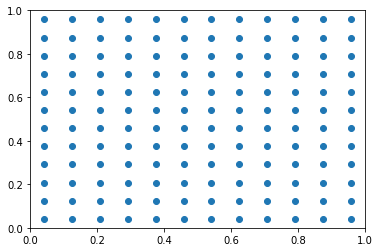

In [1640]:
# plot first anchor grid centers
print(f"number of anchors: {anc_grids[0]}")
plot_anchors(anc_x[:anc_grids[0]**2], anc_y[:anc_grids[0]**2])

In [1641]:
# plot second anchor grid centers
print(f"number of anchors: {anc_grids[1]}")
plot_anchors(anc_x[-anc_grids[1]**2:], anc_y[-anc_grids[1]**2:])

IndexError: list index out of range

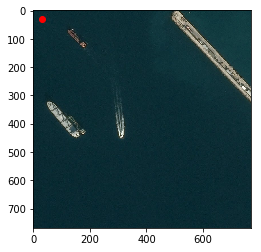

In [1642]:
# axis centers are different in imshow
plt.imshow(ima)
plt.scatter(30, 30, c='red')

In [1643]:
# anchor centers, one grid centers at a time
# goes like x1, y1 - x1, y2 - x1 - y3, ..., x2, y1, x2, y2, x2, y3 ...
# if x = row, y = column then we will go up down to right in image
anc_cntrs = np.stack([anc_x, anc_y], axis=1)
anc_cntrs

array([[0.04167, 0.04167],
       [0.04167, 0.125  ],
       [0.04167, 0.20833],
       [0.04167, 0.29167],
       [0.04167, 0.375  ],
       [0.04167, 0.45833],
       [0.04167, 0.54167],
       [0.04167, 0.625  ],
       [0.04167, 0.70833],
       [0.04167, 0.79167],
       [0.04167, 0.875  ],
       [0.04167, 0.95833],
       [0.125  , 0.04167],
       [0.125  , 0.125  ],
       [0.125  , 0.20833],
       [0.125  , 0.29167],
       [0.125  , 0.375  ],
       [0.125  , 0.45833],
       [0.125  , 0.54167],
       [0.125  , 0.625  ],
       [0.125  , 0.70833],
       [0.125  , 0.79167],
       [0.125  , 0.875  ],
       [0.125  , 0.95833],
       [0.20833, 0.04167],
       [0.20833, 0.125  ],
       [0.20833, 0.20833],
       [0.20833, 0.29167],
       [0.20833, 0.375  ],
       [0.20833, 0.45833],
       [0.20833, 0.54167],
       [0.20833, 0.625  ],
       [0.20833, 0.70833],
       [0.20833, 0.79167],
       [0.20833, 0.875  ],
       [0.20833, 0.95833],
       [0.29167, 0.04167],
 

In [1644]:
# repeat all center k times 
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [1645]:
anc_ctrs

array([[0.04167, 0.04167],
       [0.04167, 0.04167],
       [0.04167, 0.04167],
       ...,
       [0.95833, 0.95833],
       [0.95833, 0.95833],
       [0.95833, 0.95833]])

In [1646]:
# anchor scales = aspect ratio * zoom
# height and width, given x = row and y = column
# same order as anc_ctrs
anc_sizes = np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])

In [1647]:
anc_sizes[:144*9]

array([[0.04167, 0.04167],
       [0.04167, 0.02083],
       [0.02083, 0.04167],
       ...,
       [0.16667, 0.16667],
       [0.16667, 0.08333],
       [0.08333, 0.16667]])

In [1648]:
anc_sizes[144*9:]

array([], shape=(0, 2), dtype=float64)

In [1649]:
anchor_scales[0][0] /12

0.041666666666666664

In [1650]:
anchor_scales[1][0] /18

0.027777777777777776

In [1651]:
grid_sizes = V(np.concatenate([np.array([ 1/ag for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)

In [1652]:
grid_sizes

Variable containing:
1.00000e-02 *
 8.3333
 8.3333
 8.3333
   ⋮    
 8.3333
 8.3333
 8.3333
[torch.FloatTensor of size 1296x1]

In [1653]:
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [1654]:
# row, column center, height width
anchors

Variable containing:
 0.0417  0.0417  0.0417  0.0417
 0.0417  0.0417  0.0417  0.0208
 0.0417  0.0417  0.0208  0.0417
               ⋮                
 0.9583  0.9583  0.1667  0.1667
 0.9583  0.9583  0.1667  0.0833
 0.9583  0.9583  0.0833  0.1667
[torch.FloatTensor of size 1296x4]

In [1655]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [1656]:
anchor_scales

[(0.5, 0.5),
 (0.5, 0.25),
 (0.25, 0.5),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (2.0, 2.0),
 (2.0, 1.0),
 (1.0, 2.0)]

### model

![](../SSD.png)

model should be modified to multi head if different # of anchor grid will be used

(x - K + 2P / S) + 1

In [1658]:
class StdConv(nn.Module):
    """conv - relu - batchnorm - dropout"""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [1659]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (2)*k, 3, padding=1) # classification
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) # bbox offset prediction
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [1705]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        #print(x.shape)
        x = self.drop(F.relu(x))
        #print(x.shape)
        x = self.sconv0(x)
        #print(x.shape)
        x = self.sconv2(x)
        #print(x.shape)
        return self.out(x)

In [1706]:
head_reg4 = SSD_Head(k, -3.)

In [1707]:
f_model=resnet34
sz=768

In [1708]:
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

In [1709]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [1710]:
x,y = next(iter(learn.data.trn_dl))

In [1711]:
x.shape

torch.Size([16, 3, 768, 768])

In [1667]:
outs = learn.model(V(x))

torch.Size([16, 512, 24, 24])
torch.Size([16, 512, 24, 24])
torch.Size([16, 256, 24, 24])
torch.Size([16, 256, 12, 12])


### check receptive field match with anchor orders

with multihead we can flatten the out with the same method and then concatenate grid1, grid2, ..., gridn

In [1712]:
dummy_out = torch.from_numpy(np.arange(18*12*12).reshape(1, 18, 12, 12))

In [1713]:
dummy_out.shape

torch.Size([1, 18, 12, 12])

In [1683]:
dummy_reshaped = dummy_out.permute(0,2,3,1).contiguous().view(1,-1,18//k)

In [1688]:
# preds for loc x1, y1 after reshape
dummy_reshaped[:, :9]


(0 ,.,.) = 
     0   144
   288   432
   576   720
   864  1008
  1152  1296
  1440  1584
  1728  1872
  2016  2160
  2304  2448
[torch.LongTensor of size 1x9x2]

In [1689]:
# preds for loc x1, y2 after reshape
dummy_reshaped[:, 9:18]


(0 ,.,.) = 
     1   145
   289   433
   577   721
   865  1009
  1153  1297
  1441  1585
  1729  1873
  2017  2161
  2305  2449
[torch.LongTensor of size 1x9x2]

In [1677]:
# preds for loc x1, y1
dummy_out[:, :, 0, 0]



Columns 0 to 12 
    0   144   288   432   576   720   864  1008  1152  1296  1440  1584  1728

Columns 13 to 17 
 1872  2016  2160  2304  2448
[torch.LongTensor of size 1x18]

In [1679]:
# preds for loc x1, y2
dummy_out[:, :, 0, 1]



Columns 0 to 12 
    1   145   289   433   577   721   865  1009  1153  1297  1441  1585  1729

Columns 13 to 17 
 1873  2017  2161  2305  2449
[torch.LongTensor of size 1x18]

### Train

In [1714]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(2)

In [1715]:
def intersect(box_a, box_b):
    # box_i -> (min row, min col, max row, max col)
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:]) # min of the max xy s
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2]) # max of the min xy s
    inter = torch.clamp((max_xy - min_xy), min=0) 
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [1716]:
b1, b2 = T([[0, 0, 3, 3]]), T([[0, 0, 5, 5]])
box_sz(b1); box_sz(b2)


 25
[torch.LongTensor of size 1]

In [1717]:
grid_sizes

Variable containing:
1.00000e-02 *
 8.3333
 8.3333
 8.3333
   ⋮    
 8.3333
 8.3333
 8.3333
[torch.FloatTensor of size 1296x1]

In [1824]:
from torch import FloatTensor as FT

def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

# Modifying Anchor Boxes with Offset Predictions
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn) # squeeshes between -1, 1
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2] # move the center between (-0.5, 0.5) of the size so that we are still in receptive field
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:] # expand original height and width with between (0.5, 1.5)
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    #print("inside map_to_ground_truth")
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    #print("inside ssd_1_loss")
    #pdb.set_trace()
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap, gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = 0 #len(id2cat) - set for background class (no ship class)
    gt_bbox = bbox[gt_idx] # collects gt bboxes for anchors
    #loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #clas_loss  = loss_f(b_c, gt_clas) - for multi class
    loc_loss = F.smooth_l1_loss(a_ic[pos_idx], gt_bbox[pos_idx])
    clas_loss  = F.cross_entropy(b_c, gt_clas) # for single class
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    # multibox_loss = confidence_loss + alpha * location_loss
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs*10

In [1825]:
# uncomment to debug on cpu
anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu();  anchor_cnr = anchor_cnr.cpu(); len(anchors)

1296

In [1826]:
layers_groups = learn.get_layer_groups()

In [1827]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [1828]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss                          
    0      4.959564   2.888946  


[array([2.88895])]

In [1829]:
learn.fit(lr, 10)

epoch      trn_loss   val_loss                          
    0      8.645363   1.112982  
    1      5.066759   15.235564                         
    2      4.221886   39.256756                         
    3      4.099858   8.060834                          
    4      3.90005    3.687647                          
    5      3.748895   3.249426                          
    6      3.566789   5.953095                          
    7      3.388638   11.01896                          
    8      3.202213   7.239927                          
    9      3.095627   2.171606                         


[array([2.17161])]

### test results

In [1830]:
from detect_plots import draw_bbox, draw_text

In [1902]:
x,y = next(iter(md.trn_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [1903]:
b_clas.size(),b_bb.size()

(torch.Size([16, 1296, 2]), torch.Size([16, 1296, 4]))

In [1966]:
idx=5
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.8490  0.0872  0.8620  0.0990
 [torch.FloatTensor of size 1x4], Variable containing:
  1
 [torch.LongTensor of size 1])

In [1967]:
actual_bb = to_np(bbox).copy()

In [1968]:
#  min_y, min_x, max_y, max_x
a_ic = actn_to_bb(b_bboxi, anchors)

(array([1273.,    9.,    4.,    3.,    1.,    2.,    1.,    0.,    1.,    2.]),
 array([0.     , 0.00055, 0.0011 , 0.00166, 0.00221, 0.00276, 0.00331, 0.00387, 0.00442, 0.00497, 0.00552]),
 <a list of 10 Patch objects>)

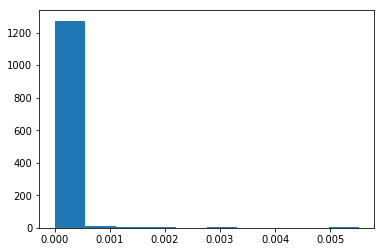

In [1969]:
pred_proba = to_np(F.softmax(b_clasi))[:, 1]
plt.hist(pred_proba)

In [1970]:
t = 0.7
pred_bbox_mask = pred_proba > t

In [1971]:
pred_bbox_probas = np.round(pred_proba[pred_bbox_mask],2); pred_bbox_probas

array([], dtype=float32)

In [1972]:
# corner preds
pred_bbox_corner = to_np(a_ic*SZ).astype(int)[pred_bbox_mask]

In [1973]:
#actual
actual_bbox = actual_bb*SZ

In [1974]:
actual_bbox

array([[652.,  67., 662.,  76.]], dtype=float32)

In [1975]:
# preds
pred_bbox_corner

array([], shape=(0, 4), dtype=int64)

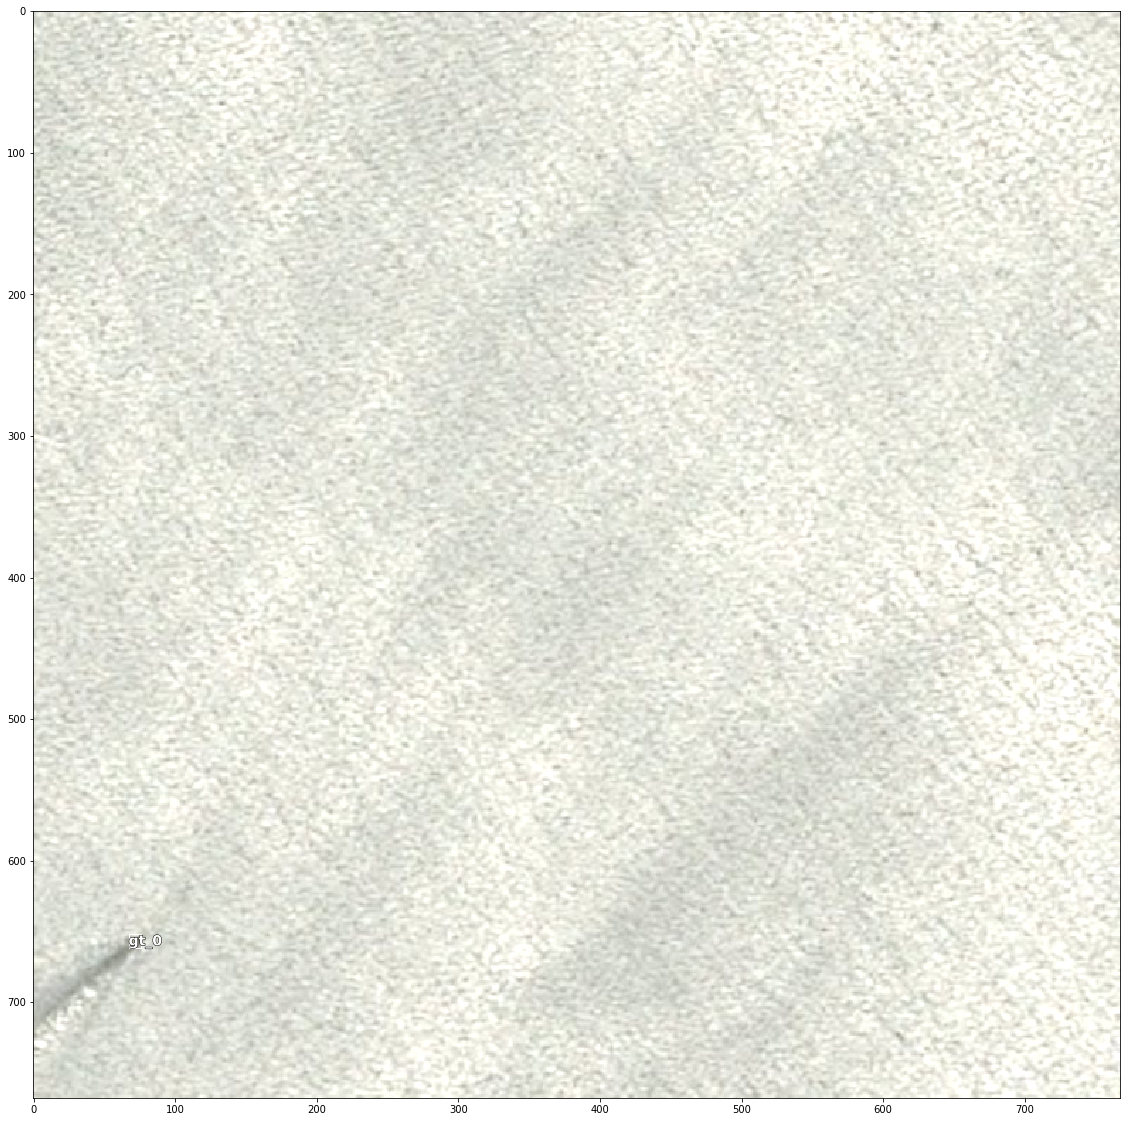

In [1976]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(ima)
for i, (bbox, proba) in enumerate(zip(pred_bbox_corner, pred_bbox_probas)): 
    draw_bbox(bbox, axes)
    draw_text(axes, bbox[:2][::-1], f"pred_{i}")
    draw_text(axes, bbox[:2][::-1], f"proba:{proba}")
    
for i, bbox in enumerate(actual_bbox): draw_bbox(bbox, axes, "white"); draw_text(axes, bbox[:2][::-1], f"gt_{i}")